In [ ]:
import os
import torchvision.models as models 
import torch.nn as nn
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset, DataLoader, random_split
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision
from glob import glob
from torchinfo import summary
import numpy as np
import torch.functional as F
import torchvision.transforms as T
from tqdm.notebook import tqdm
import torchmetrics
device0 = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
Type_class='Type_All'
batch_size=256

dataload

In [ ]:
#fit
class CustomDataset(Dataset):
    def __init__(self, data,label ,transform=None, target_transform=None):
        self.PPG_data=data
        self.PPG_label=label
    def __len__(self):
        return len(self.PPG_data)

    def __getitem__(self, idx):
        signal_tensor=self.PPG_data[idx]
        AF_signal_label=self.PPG_label[idx]
        return signal_tensor,AF_signal_label
    
train_csv_path ='../../data/AF/Waveform/train/'
test_csv_path ='../../data/AF/Waveform/test/'

train_data_list=glob(train_csv_path+Type_class+'/**/*.csv')
test_data_list=glob(test_csv_path+Type_class+'/**/*.csv')
train_data=torch.empty(len(train_data_list),1,1000)
train_label=torch.empty(len(train_data_list),1)
test_data=torch.empty(len(test_data_list),1,1000)
test_label=torch.empty(len(test_data_list),1)
for i in range(len(train_data_list)):
    signal_csv=pd.read_csv(train_data_list[i])['PPG'].to_numpy()
    train_data_list[i].find('positive')
    AF_signal_label=0
    if train_data_list[i].find('positive')!=-1:
        AF_signal_label=1
    else:
        AF_signal_label=0
    train_data[i]=torch.tensor(signal_csv)
    train_label[i]=torch.tensor([AF_signal_label])
    
for i in range(len(test_data_list)):
    signal_csv=pd.read_csv(test_data_list[i])['PPG'].to_numpy()
    test_data_list[i].find('positive')
    AF_signal_label=0
    if test_data_list[i].find('positive')!=-1:
        AF_signal_label=1
    else:
        AF_signal_label=0
    test_data[i]=torch.tensor(signal_csv)
    test_label[i]=torch.tensor([AF_signal_label])

train_dataset=CustomDataset(train_data,train_label)
test_dataset=CustomDataset(test_data ,test_label)
dataset_size = len(test_dataset)
test_size = int(dataset_size * 0.5)
validation_size = dataset_size-test_size
validation_dataset, test_dataset = random_split(test_dataset, [validation_size, test_size])
train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
validation_dataloader = DataLoader(validation_dataset, batch_size=batch_size, shuffle=True, drop_last=True)
test_dataloader = DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=True)

model

In [26]:
from sympy import flatten


class CNN1D(nn.Module):
    def __init__(self):
        super(CNN1D,self).__init__()
        self.conv1=nn.Conv1d(in_channels=1, out_channels=50, kernel_size=3,padding='same', padding_mode='replicate')
        self.relu=nn.ReLU()
        self.dropout=nn.Dropout1d(0.5)
        self.pool1=torch.nn.MaxPool1d(kernel_size=5)
        self.conv2=nn.Conv1d(in_channels=50, out_channels=50, kernel_size=3,padding='same', padding_mode='replicate')
        self.relu2=nn.ReLU()
        self.dropout2=nn.Dropout1d(0.5)
        self.pool2=torch.nn.MaxPool1d(kernel_size=5)
        self.fc1=nn.Linear(50*40, 200, bias=False)
        self.fc2=nn.Linear(200, 1, bias=False)
    def forward(self,x):
        
        x=self.conv1(x)
        x=self.relu(x)
        x=self.dropout(x)
        x=self.pool1(x)
        x=self.conv2(x)
        x=self.relu2(x)
        x=self.dropout2(x)
        x=self.pool2(x)
        x = torch.flatten(x, 1)
        x=self.fc1(x)
        x=self.fc2(x)
        return x


    
accuracy = torchmetrics.Accuracy(task="binary", num_classes=1).to(device0)
model = CNN1D().to(device0)
criterion = nn.BCEWithLogitsLoss().to(device0)
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
summary(model,(batch_size,1,1000))

Layer (type:depth-idx)                   Output Shape              Param #
CNN1D                                    [256, 1]                  --
├─Conv1d: 1-1                            [256, 50, 1000]           200
├─ReLU: 1-2                              [256, 50, 1000]           --
├─Dropout1d: 1-3                         [256, 50, 1000]           --
├─MaxPool1d: 1-4                         [256, 50, 200]            --
├─Conv1d: 1-5                            [256, 50, 200]            7,550
├─ReLU: 1-6                              [256, 50, 200]            --
├─Dropout1d: 1-7                         [256, 50, 200]            --
├─MaxPool1d: 1-8                         [256, 50, 40]             --
├─Linear: 1-9                            [256, 200]                400,000
├─Linear: 1-10                           [256, 1]                  200
Total params: 407,950
Trainable params: 407,950
Non-trainable params: 0
Total mult-adds (M): 540.21
Input size (MB): 1.02
Forward/backward pass s

Train

epoch: 1/1000 train_loss : 0.6875 train_accuracy: 0.5355 val_loss : 0.6640  val_accuracy: 0.6118
epoch: 2/1000 train_loss : 0.6691 train_accuracy: 0.5813 val_loss : 0.6478  val_accuracy: 0.6002


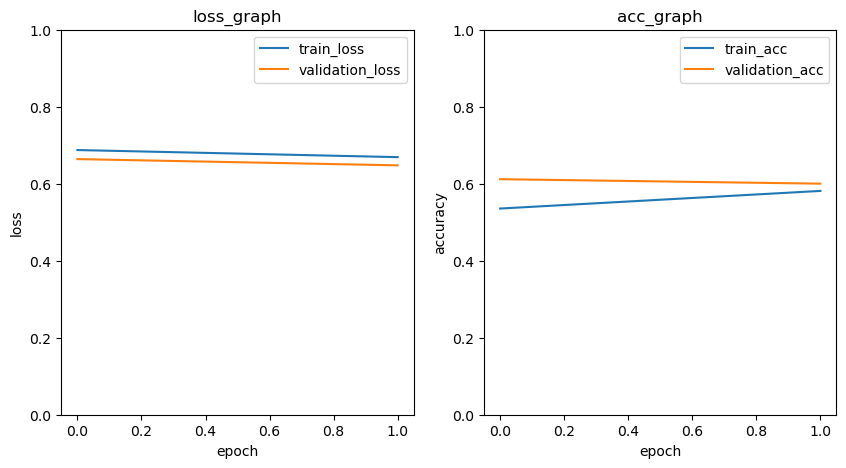

epoch: 3/1000 train_loss : 0.6638 train_accuracy: 0.5885 val_loss : 0.6433  val_accuracy: 0.6128
epoch: 4/1000 train_loss : 0.6608 train_accuracy: 0.5925 val_loss : 0.6404  val_accuracy: 0.6007
epoch: 5/1000 train_loss : 0.6571 train_accuracy: 0.5929 val_loss : 0.6372  val_accuracy: 0.6064
epoch: 6/1000 train_loss : 0.6544 train_accuracy: 0.5935 val_loss : 0.6335  val_accuracy: 0.5966
epoch: 7/1000 train_loss : 0.6512 train_accuracy: 0.5948 val_loss : 0.6291  val_accuracy: 0.6066
epoch: 8/1000 train_loss : 0.6450 train_accuracy: 0.5935 val_loss : 0.6089  val_accuracy: 0.6072
epoch: 9/1000 train_loss : 0.6373 train_accuracy: 0.5972 val_loss : 0.5926  val_accuracy: 0.6096
epoch: 10/1000 train_loss : 0.6329 train_accuracy: 0.6023 val_loss : 0.5840  val_accuracy: 0.6327
epoch: 11/1000 train_loss : 0.6182 train_accuracy: 0.6197 val_loss : 0.5657  val_accuracy: 0.6881
epoch: 12/1000 train_loss : 0.5948 train_accuracy: 0.6569 val_loss : 0.5159  val_accuracy: 0.7190
epoch: 13/1000 train_loss :

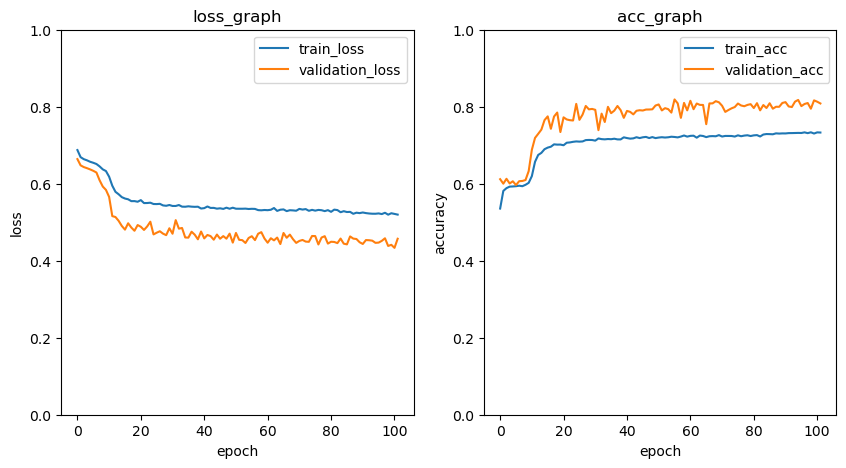

epoch: 103/1000 train_loss : 0.5190 train_accuracy: 0.7337 val_loss : 0.4464  val_accuracy: 0.8067
epoch: 104/1000 train_loss : 0.5218 train_accuracy: 0.7327 val_loss : 0.4709  val_accuracy: 0.8141
epoch: 105/1000 train_loss : 0.5216 train_accuracy: 0.7314 val_loss : 0.4585  val_accuracy: 0.7914
epoch: 106/1000 train_loss : 0.5203 train_accuracy: 0.7319 val_loss : 0.4472  val_accuracy: 0.8093
epoch: 107/1000 train_loss : 0.5166 train_accuracy: 0.7370 val_loss : 0.4467  val_accuracy: 0.8098
epoch: 108/1000 train_loss : 0.5219 train_accuracy: 0.7314 val_loss : 0.4458  val_accuracy: 0.7898
epoch: 109/1000 train_loss : 0.5195 train_accuracy: 0.7334 val_loss : 0.4439  val_accuracy: 0.8145
epoch: 110/1000 train_loss : 0.5202 train_accuracy: 0.7330 val_loss : 0.4584  val_accuracy: 0.7801
epoch: 111/1000 train_loss : 0.5176 train_accuracy: 0.7332 val_loss : 0.4629  val_accuracy: 0.7937
epoch: 112/1000 train_loss : 0.5205 train_accuracy: 0.7343 val_loss : 0.4443  val_accuracy: 0.8175
epoch: 113

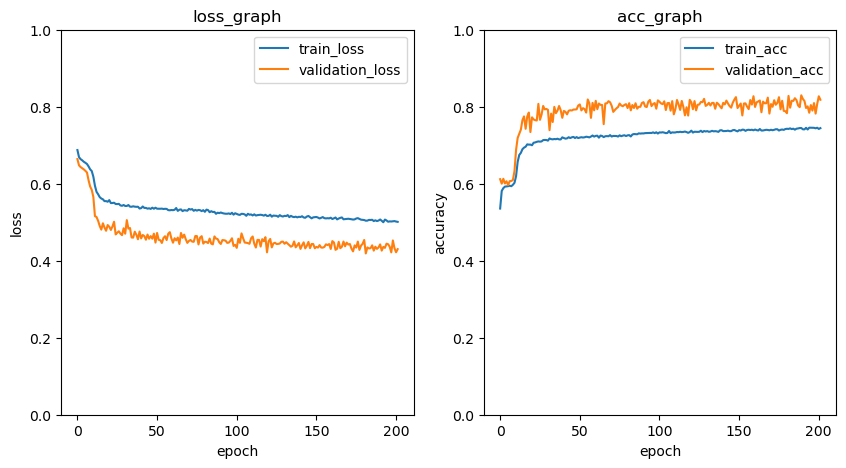

epoch: 203/1000 train_loss : 0.5016 train_accuracy: 0.7465 val_loss : 0.4335  val_accuracy: 0.8219
epoch: 204/1000 train_loss : 0.4996 train_accuracy: 0.7461 val_loss : 0.4277  val_accuracy: 0.8144
epoch: 205/1000 train_loss : 0.4973 train_accuracy: 0.7473 val_loss : 0.4404  val_accuracy: 0.7824
epoch: 206/1000 train_loss : 0.5002 train_accuracy: 0.7459 val_loss : 0.4223  val_accuracy: 0.8177
epoch: 207/1000 train_loss : 0.5007 train_accuracy: 0.7467 val_loss : 0.4387  val_accuracy: 0.7840
epoch: 208/1000 train_loss : 0.5020 train_accuracy: 0.7441 val_loss : 0.4315  val_accuracy: 0.8076
epoch: 209/1000 train_loss : 0.5026 train_accuracy: 0.7453 val_loss : 0.4489  val_accuracy: 0.7762
epoch: 210/1000 train_loss : 0.5005 train_accuracy: 0.7455 val_loss : 0.4199  val_accuracy: 0.8200
epoch: 211/1000 train_loss : 0.4997 train_accuracy: 0.7472 val_loss : 0.4363  val_accuracy: 0.7966
epoch: 212/1000 train_loss : 0.5025 train_accuracy: 0.7456 val_loss : 0.4333  val_accuracy: 0.7971
epoch: 213

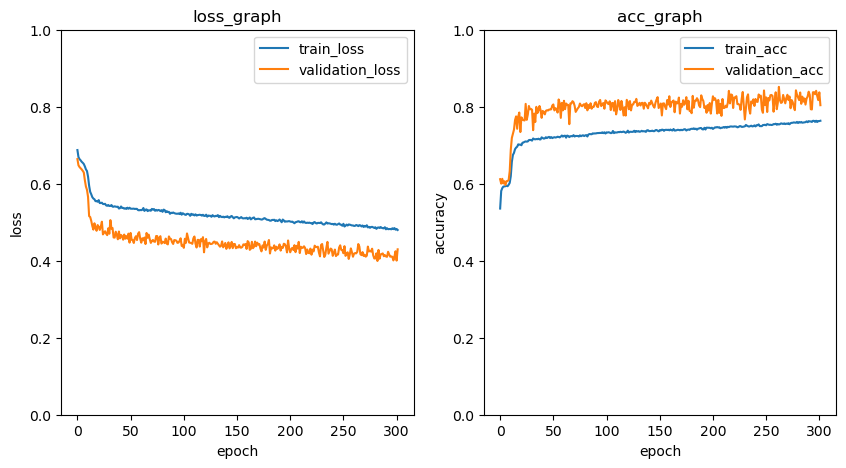

epoch: 303/1000 train_loss : 0.4789 train_accuracy: 0.7658 val_loss : 0.3940  val_accuracy: 0.8399
epoch: 304/1000 train_loss : 0.4827 train_accuracy: 0.7617 val_loss : 0.4322  val_accuracy: 0.7991
epoch: 305/1000 train_loss : 0.4812 train_accuracy: 0.7631 val_loss : 0.4113  val_accuracy: 0.8173
epoch: 306/1000 train_loss : 0.4815 train_accuracy: 0.7636 val_loss : 0.4062  val_accuracy: 0.8345
epoch: 307/1000 train_loss : 0.4769 train_accuracy: 0.7655 val_loss : 0.3833  val_accuracy: 0.8462
epoch: 308/1000 train_loss : 0.4778 train_accuracy: 0.7656 val_loss : 0.4077  val_accuracy: 0.8450
epoch: 309/1000 train_loss : 0.4793 train_accuracy: 0.7638 val_loss : 0.3851  val_accuracy: 0.8388
epoch: 310/1000 train_loss : 0.4778 train_accuracy: 0.7654 val_loss : 0.4155  val_accuracy: 0.8075
epoch: 311/1000 train_loss : 0.4802 train_accuracy: 0.7659 val_loss : 0.4152  val_accuracy: 0.8071
epoch: 312/1000 train_loss : 0.4777 train_accuracy: 0.7647 val_loss : 0.4029  val_accuracy: 0.8219
epoch: 313

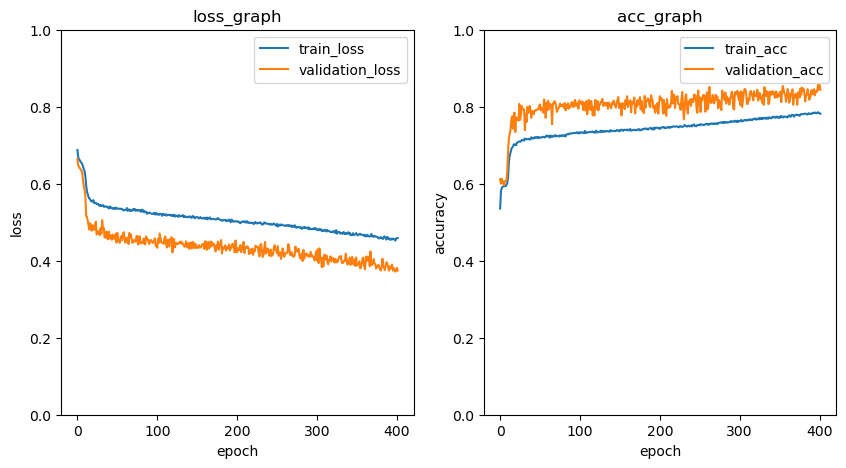

epoch: 403/1000 train_loss : 0.4546 train_accuracy: 0.7841 val_loss : 0.3926  val_accuracy: 0.8401
epoch: 404/1000 train_loss : 0.4548 train_accuracy: 0.7821 val_loss : 0.3860  val_accuracy: 0.8205
epoch: 405/1000 train_loss : 0.4561 train_accuracy: 0.7844 val_loss : 0.3765  val_accuracy: 0.8375
epoch: 406/1000 train_loss : 0.4528 train_accuracy: 0.7864 val_loss : 0.3867  val_accuracy: 0.8456
epoch: 407/1000 train_loss : 0.4548 train_accuracy: 0.7853 val_loss : 0.3646  val_accuracy: 0.8491
epoch: 408/1000 train_loss : 0.4532 train_accuracy: 0.7837 val_loss : 0.3892  val_accuracy: 0.8281
epoch: 409/1000 train_loss : 0.4568 train_accuracy: 0.7834 val_loss : 0.3963  val_accuracy: 0.8282
epoch: 410/1000 train_loss : 0.4541 train_accuracy: 0.7858 val_loss : 0.3826  val_accuracy: 0.8345
epoch: 411/1000 train_loss : 0.4546 train_accuracy: 0.7859 val_loss : 0.3889  val_accuracy: 0.8275
epoch: 412/1000 train_loss : 0.4588 train_accuracy: 0.7815 val_loss : 0.3813  val_accuracy: 0.8378
epoch: 413

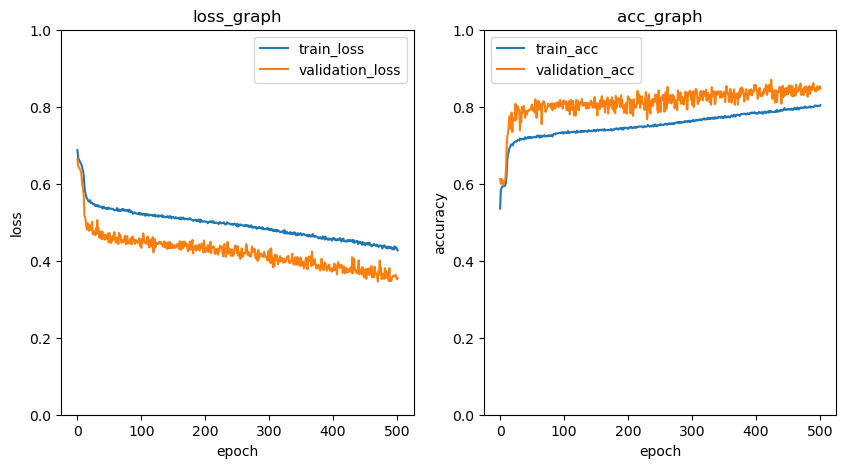

epoch: 503/1000 train_loss : 0.4287 train_accuracy: 0.8041 val_loss : 0.3741  val_accuracy: 0.8324
epoch: 504/1000 train_loss : 0.4310 train_accuracy: 0.8021 val_loss : 0.3467  val_accuracy: 0.8582
epoch: 505/1000 train_loss : 0.4298 train_accuracy: 0.7992 val_loss : 0.3497  val_accuracy: 0.8522
epoch: 506/1000 train_loss : 0.4278 train_accuracy: 0.8031 val_loss : 0.3678  val_accuracy: 0.8388
epoch: 507/1000 train_loss : 0.4306 train_accuracy: 0.8035 val_loss : 0.3574  val_accuracy: 0.8406
epoch: 508/1000 train_loss : 0.4300 train_accuracy: 0.8038 val_loss : 0.3408  val_accuracy: 0.8565
epoch: 509/1000 train_loss : 0.4272 train_accuracy: 0.8027 val_loss : 0.3470  val_accuracy: 0.8572
epoch: 510/1000 train_loss : 0.4294 train_accuracy: 0.8056 val_loss : 0.3467  val_accuracy: 0.8647
epoch: 511/1000 train_loss : 0.4312 train_accuracy: 0.8022 val_loss : 0.3593  val_accuracy: 0.8540
epoch: 512/1000 train_loss : 0.4297 train_accuracy: 0.8023 val_loss : 0.3644  val_accuracy: 0.8474
epoch: 513

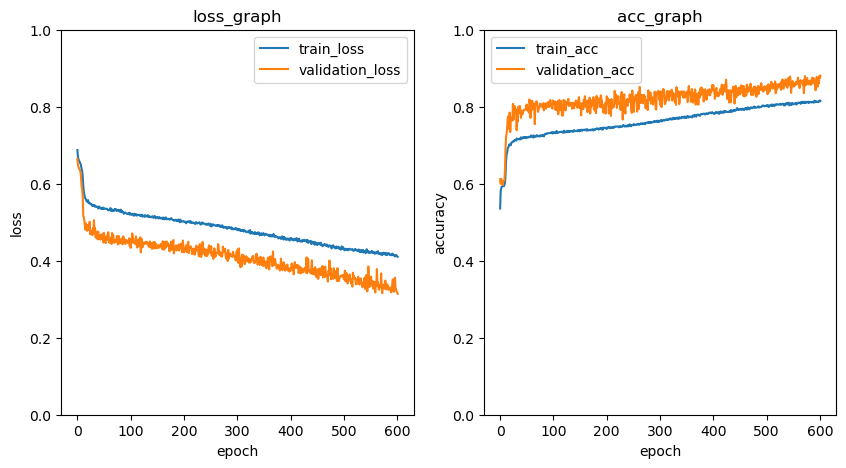

epoch: 603/1000 train_loss : 0.4143 train_accuracy: 0.8154 val_loss : 0.3438  val_accuracy: 0.8638
epoch: 604/1000 train_loss : 0.4129 train_accuracy: 0.8134 val_loss : 0.3298  val_accuracy: 0.8699
epoch: 605/1000 train_loss : 0.4137 train_accuracy: 0.8147 val_loss : 0.3306  val_accuracy: 0.8698
epoch: 606/1000 train_loss : 0.4149 train_accuracy: 0.8109 val_loss : 0.3123  val_accuracy: 0.8874
epoch: 607/1000 train_loss : 0.4146 train_accuracy: 0.8169 val_loss : 0.3195  val_accuracy: 0.8727
epoch: 608/1000 train_loss : 0.4080 train_accuracy: 0.8151 val_loss : 0.3385  val_accuracy: 0.8654
epoch: 609/1000 train_loss : 0.4153 train_accuracy: 0.8119 val_loss : 0.3151  val_accuracy: 0.8731
epoch: 610/1000 train_loss : 0.4099 train_accuracy: 0.8155 val_loss : 0.3099  val_accuracy: 0.8742
epoch: 611/1000 train_loss : 0.4114 train_accuracy: 0.8140 val_loss : 0.3177  val_accuracy: 0.8766
epoch: 612/1000 train_loss : 0.4072 train_accuracy: 0.8173 val_loss : 0.3128  val_accuracy: 0.8712
epoch: 613

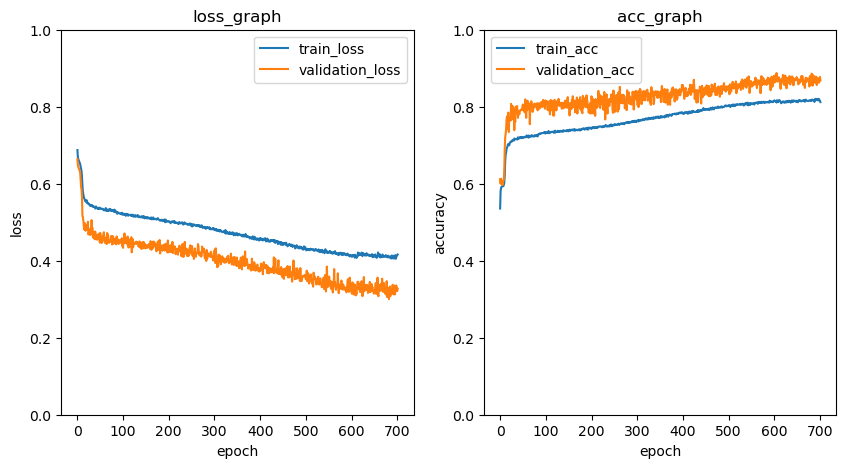

epoch: 703/1000 train_loss : 0.4111 train_accuracy: 0.8150 val_loss : 0.3443  val_accuracy: 0.8479
epoch: 704/1000 train_loss : 0.4115 train_accuracy: 0.8128 val_loss : 0.3452  val_accuracy: 0.8644
epoch: 705/1000 train_loss : 0.4126 train_accuracy: 0.8154 val_loss : 0.3186  val_accuracy: 0.8683
epoch: 706/1000 train_loss : 0.4175 train_accuracy: 0.8122 val_loss : 0.3239  val_accuracy: 0.8701
epoch: 707/1000 train_loss : 0.4093 train_accuracy: 0.8149 val_loss : 0.3271  val_accuracy: 0.8776
epoch: 708/1000 train_loss : 0.4150 train_accuracy: 0.8147 val_loss : 0.3247  val_accuracy: 0.8762
epoch: 709/1000 train_loss : 0.4126 train_accuracy: 0.8154 val_loss : 0.3378  val_accuracy: 0.8644
epoch: 710/1000 train_loss : 0.4107 train_accuracy: 0.8170 val_loss : 0.3379  val_accuracy: 0.8561
epoch: 711/1000 train_loss : 0.4185 train_accuracy: 0.8135 val_loss : 0.3228  val_accuracy: 0.8815
epoch: 712/1000 train_loss : 0.4123 train_accuracy: 0.8156 val_loss : 0.3225  val_accuracy: 0.8746
epoch: 713

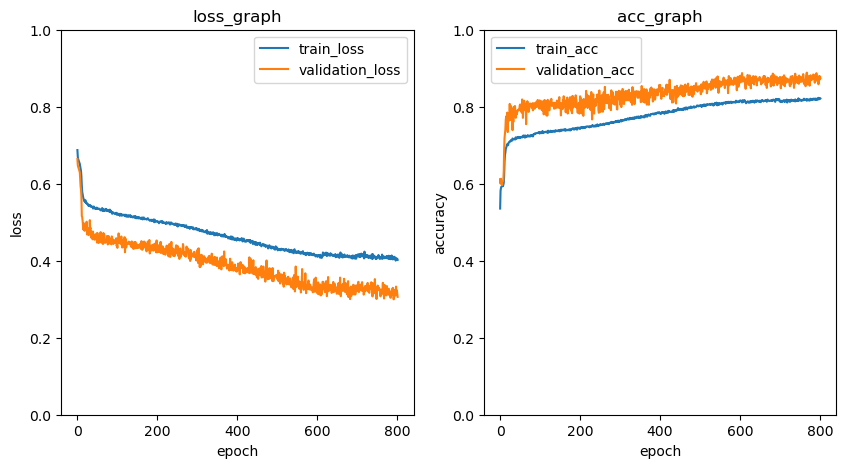

epoch: 803/1000 train_loss : 0.4042 train_accuracy: 0.8211 val_loss : 0.3268  val_accuracy: 0.8836
epoch: 804/1000 train_loss : 0.4114 train_accuracy: 0.8190 val_loss : 0.3369  val_accuracy: 0.8673
epoch: 805/1000 train_loss : 0.4108 train_accuracy: 0.8171 val_loss : 0.3122  val_accuracy: 0.8817
epoch: 806/1000 train_loss : 0.4069 train_accuracy: 0.8216 val_loss : 0.3183  val_accuracy: 0.8696
epoch: 807/1000 train_loss : 0.4023 train_accuracy: 0.8219 val_loss : 0.3188  val_accuracy: 0.8668
epoch: 808/1000 train_loss : 0.4078 train_accuracy: 0.8175 val_loss : 0.3018  val_accuracy: 0.8822
epoch: 809/1000 train_loss : 0.4028 train_accuracy: 0.8243 val_loss : 0.3209  val_accuracy: 0.8691
epoch: 810/1000 train_loss : 0.4110 train_accuracy: 0.8175 val_loss : 0.3229  val_accuracy: 0.8708
epoch: 811/1000 train_loss : 0.4072 train_accuracy: 0.8207 val_loss : 0.3217  val_accuracy: 0.8666
epoch: 812/1000 train_loss : 0.3991 train_accuracy: 0.8223 val_loss : 0.3084  val_accuracy: 0.8844
epoch: 813

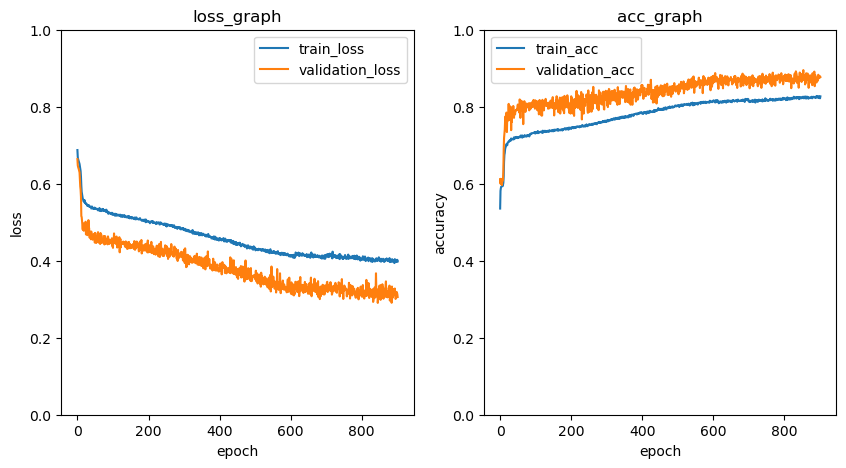

epoch: 903/1000 train_loss : 0.3971 train_accuracy: 0.8256 val_loss : 0.3140  val_accuracy: 0.8733
epoch: 904/1000 train_loss : 0.4071 train_accuracy: 0.8216 val_loss : 0.3137  val_accuracy: 0.8802
epoch: 905/1000 train_loss : 0.3976 train_accuracy: 0.8260 val_loss : 0.2972  val_accuracy: 0.8887
epoch: 906/1000 train_loss : 0.3988 train_accuracy: 0.8267 val_loss : 0.3167  val_accuracy: 0.8698
epoch: 907/1000 train_loss : 0.3957 train_accuracy: 0.8259 val_loss : 0.3058  val_accuracy: 0.8809
epoch: 908/1000 train_loss : 0.3988 train_accuracy: 0.8225 val_loss : 0.3140  val_accuracy: 0.8724
epoch: 909/1000 train_loss : 0.3958 train_accuracy: 0.8261 val_loss : 0.3210  val_accuracy: 0.8697
epoch: 910/1000 train_loss : 0.4017 train_accuracy: 0.8256 val_loss : 0.3188  val_accuracy: 0.8735
epoch: 911/1000 train_loss : 0.3979 train_accuracy: 0.8255 val_loss : 0.3140  val_accuracy: 0.8713
epoch: 912/1000 train_loss : 0.3989 train_accuracy: 0.8294 val_loss : 0.3216  val_accuracy: 0.8816
epoch: 913

In [27]:
MIN_loss=5000
train_loss_list=[]
val_loss_list=[]
train_acc_list=[]
val_acc_list=[]
for epoch in range(1000):
    
    train_count=0
    running_loss = 0.0
    acc_loss=0
    for x, y in train_dataloader:
        model.train()
        y = y.to(device0).float()
        train_count+=1
        x=x.to(device0).float()
        optimizer.zero_grad()  # optimizer zero 로 초기화
        predict = model(x).to(device0)
        cost = criterion(predict, y) # cost 구함
        acc=accuracy(predict, y)
        cost.backward() # cost에 대한 backward 구함
        optimizer.step() 
        running_loss += cost.item()
        acc_loss+=acc
    
    train_loss_list.append((running_loss/train_count))
    train_acc_list.append((acc_loss/train_count).cpu().detach().numpy())
#validation
    model.eval()
    val_count=0
    val_running_loss=0.0
    val_acc_loss=0
    with torch.no_grad():
        for x, y in validation_dataloader:
            y = y.to(device0).float()
            val_count+=1
            x=x.to(device0).float()
            
            predict = model(x).to(device0)
            acc=accuracy(predict, y)
            cost = criterion(predict, y)
            val_running_loss+=cost.item()
            val_acc_loss+=acc
        print(f"\repoch: {epoch+1}/{1000} train_loss : {running_loss/train_count:.4f} train_accuracy: {acc_loss/train_count:.4f} val_loss : {val_running_loss/val_count:.4f}  val_accuracy: {val_acc_loss/val_count:.4f}")
        
        val_loss_list.append((val_running_loss/val_count))
        val_acc_list.append((val_acc_loss/val_count).cpu().detach().numpy())
    if epoch%100==1:
        plt.figure(figsize=(10,5))
        plt.subplot(1, 2, 1) 
        plt.title('loss_graph')
        plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
        plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.subplot(1, 2, 2)  
        plt.title('acc_graph')
        plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
        plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
        plt.xlabel('epoch')
        plt.ylabel('accuracy')
        plt.ylim([0, 1]) 
        plt.legend()
        plt.show()
        
    if MIN_loss>(val_running_loss/val_count):
        torch.save(model.state_dict(), '../../model/Waveform/'+Type_class+'/BiLSTM_CNN_1D_10_TypeAll_call_back.pt')
        MIN_loss=(val_running_loss/val_count)
torch.save(model.state_dict(), '../../model/Waveform/'+Type_class+'/BiLSTM_CNN_1D_10_TypeAll.pt')

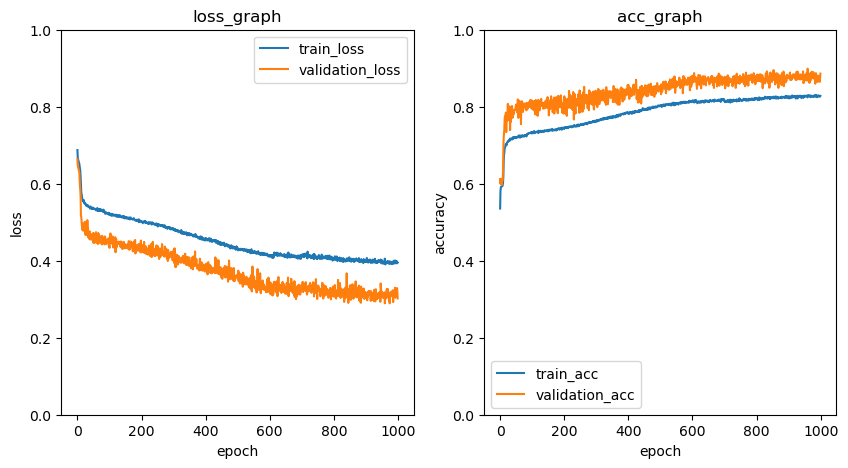

: 

In [28]:
plt.figure(figsize=(10,5))
plt.subplot(1, 2, 1) 
plt.title('loss_graph')
plt.plot(np.arange(epoch+1),train_loss_list,label='train_loss')
plt.plot(np.arange(epoch+1),val_loss_list,label='validation_loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.ylim([0, 1]) 
plt.legend()
plt.subplot(1, 2, 2)  
plt.title('acc_graph')
plt.plot(np.arange(epoch+1),train_acc_list,label='train_acc')
plt.plot(np.arange(epoch+1),val_acc_list,label='validation_acc')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.ylim([0, 1]) 
plt.legend()
plt.show()